In [1]:
import json
import torch
from torch.utils.data import Dataset
import sentencepiece as spm

class TextDataset(Dataset):
    def __init__(self, file_path, sp_model_path, max_len=512):
        self.data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                obj = json.loads(line)
                prompt = obj.get('prompt', '').strip()
                completion = obj.get('completion', '').strip()
                if prompt or completion:
                    full_text = (prompt + " " + completion).strip()
                    self.data.append(full_text)

        self.sp = spm.SentencePieceProcessor()
        self.sp.load(sp_model_path)
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        token_ids = self.sp.encode(text, out_type=int)[:self.max_len]
        input_ids = torch.tensor(token_ids[:-1], dtype=torch.long)
        target_ids = torch.tensor(token_ids[1:], dtype=torch.long)
        return input_ids, target_ids


In [2]:
import torch.nn as nn
import torch

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=768, num_layers=2):
        super(RNNLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embeds = self.embedding(x)
        output, hidden = self.rnn(embeds, hidden)
        logits = self.fc(output)
        return logits, hidden

    def sample_with_temperature(self, x, hidden=None, temperature=1.0, max_len=50, eos_token_id=3):
        self.eval()
        generated = x.tolist()[0]
        input_tensor = x

        with torch.no_grad():
            for _ in range(max_len):
                logits, hidden = self.forward(input_tensor, hidden)
                logits = logits[:, -1, :] / temperature  # use last token's logits
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                if next_token == eos_token_id:
                    break
                generated.append(next_token)
                input_tensor = torch.tensor([[next_token]], dtype=torch.long).to(x.device)

        return generated



In [3]:
import sentencepiece as spm
import json
import os
import gdown

def download_from_drive(file_id, output_path):
    if not os.path.exists(output_path):
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f"Downloading {output_path} from Google Drive...")
        gdown.download(url, output_path, quiet=False)

def prepare_tokenizer_input(jsonl_file, output_txt):
    count = 0
    with open(jsonl_file, 'r', encoding='utf-8') as f_in, open(output_txt, 'w', encoding='utf-8') as f_out:
        for line in f_in:
            obj = json.loads(line)
            prompt = obj.get('prompt', '').strip()
            completion = obj.get('completion', '').strip()
            if prompt or completion:
                full_text = (prompt + " " + completion).strip()
                f_out.write(full_text + '\n')
                count += 1
    print(f"[INFO] Wrote {count} lines to {output_txt}")

def train_tokenizer(input_file, model_prefix="tokenizer/bpe", vocab_size=10000):
    os.makedirs(os.path.dirname(model_prefix), exist_ok=True)
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type='bpe',
        pad_id=0, unk_id=1, bos_id=2, eos_id=3
    )

if __name__ == "__main__":
    os.makedirs("data", exist_ok=True)

    # ✅ Download from Google Drive
    file_id = "1NI1ZMYSAhtCFiZIg82tYqxNoETzOfs5D"  # train.jsonl
    local_path = "train.jsonl"
    download_from_drive(file_id, local_path)

    # ✅ Prepare tokenizer input and train
    prepare_tokenizer_input(local_path, "tokenizer_input.txt")
    train_tokenizer("tokenizer_input.txt")


[INFO] Wrote 39592 lines to tokenizer_input.txt


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: tokenizer_input.txt
  input_format: 
  model_prefix: tokenizer/bpe
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0

/work/pegahnn/envs/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - Train Loss: 6.2942 - Val Loss: 5.7968
Epoch 2/30 - Train Loss: 5.4974 - Val Loss: 5.2884
Epoch 3/30 - Train Loss: 5.0745 - Val Loss: 5.0040
Epoch 4/30 - Train Loss: 4.8167 - Val Loss: 4.9019
Epoch 5/30 - Train Loss: 4.6350 - Val Loss: 4.8584
Epoch 6/30 - Train Loss: 4.5056 - Val Loss: 4.8481
Epoch 7/30 - Train Loss: 4.3996 - Val Loss: 4.8461
Epoch 8/30 - Train Loss: 4.3123 - Val Loss: 4.8628
Epoch 9/30 - Train Loss: 4.2398 - Val Loss: 4.8602
Epoch 10/30 - Train Loss: 4.1782 - Val Loss: 4.8768
Epoch 11/30 - Train Loss: 4.1227 - Val Loss: 4.8959
Epoch 12/30 - Train Loss: 3.8396 - Val Loss: 4.8137
Epoch 13/30 - Train Loss: 3.7350 - Val Loss: 4.8287
Epoch 14/30 - Train Loss: 3.6662 - Val Loss: 4.8531
Epoch 15/30 - Train Loss: 3.6041 - Val Loss: 4.8730
Epoch 16/30 - Train Loss: 3.6019 - Val Loss: 4.8942
Epoch 17/30 - Train Loss: 3.3869 - Val Loss: 4.8758
[Early stopping] No improvement for 5 epochs.


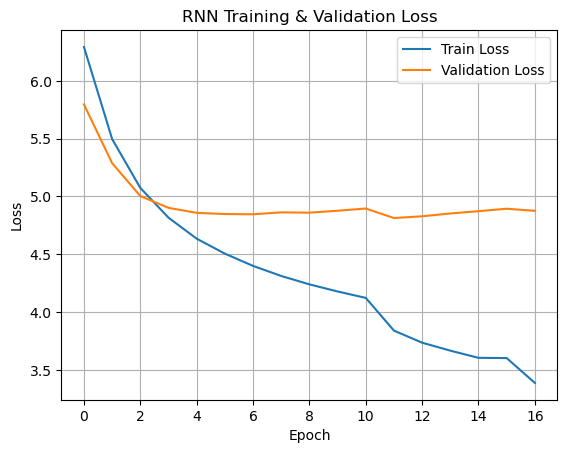


Prompt: Which do you prefer? Dogs or cats?
Generated: Which do you prefer? Dogs or cats? It is asked, but I never was the first time. He is a hyponillal, do you think? It is said, this is near me. But, said, I am not my brothers, said he. Pierre shuddered in his

Prompt: Prompt: It was a dark and stormy night when
Generated: Prompt: It was a dark and stormy night when it wasn ⁇ t, but the redhaired gunner of the eagle threw the course of the liquor of his collar and a crucifix. The man whom he had no longer anything but that Napoleon had so lately been retained, but it seemed


In [4]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sentencepiece as spm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = pad_sequence(targets, batch_first=True, padding_value=0)
    return inputs, targets

def evaluate_validation_loss(model, val_loader, criterion, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(val_loader)

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, vocab_size,
          epochs=30, early_stopping_patience=5):
    model.to(device)
    best_val_loss = float("inf")
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        val_loss = evaluate_validation_loss(model, val_loader, criterion, vocab_size)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "rnn_model_best.pt")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"[Early stopping] No improvement for {early_stopping_patience} epochs.")
                break

    return train_losses, val_losses

def plot_loss(train_losses, val_losses, model_name="RNN"):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"{model_name} Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{model_name}_loss_curve.png")
    plt.show()

def generate_with_temperature(model, sp, prompt, temperature=1.0, max_len=50):
    model.eval()
    input_ids = sp.encode(prompt, out_type=int)
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    generated = input_ids.copy()
    hidden = None

    with torch.no_grad():
        for _ in range(max_len):
            logits, hidden = model(input_tensor, hidden)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            if next_token == sp.eos_id():
                break
            generated.append(next_token)
            input_tensor = torch.tensor([[next_token]], dtype=torch.long).to(device)

    return sp.decode(generated)

if __name__ == "__main__":
    # Tokenizer
    sp_model_path = "tokenizer/bpe.model"
    sp = spm.SentencePieceProcessor()
    sp.load(sp_model_path)

    # ⬇️ Download datasets from Google Drive if needed
    os.makedirs("data", exist_ok=True)
    download_from_drive("1NI1ZMYSAhtCFiZIg82tYqxNoETzOfs5D", "train.jsonl")
    download_from_drive("13OVMdyePf7jPXDGSRFlA_1riWiQQeWim", "test.jsonl")

    # ✅ Load datasets from local disk
    train_dataset = TextDataset("train.jsonl", sp_model_path)
    val_dataset = TextDataset("test.jsonl", sp_model_path)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

    # Setup model, optimizer, scheduler
    vocab_size = 10000
    model = RNNLanguageModel(vocab_size, embed_dim=256, hidden_dim=768, num_layers=2)
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Train
    train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, scheduler, vocab_size)

    # Save final model
    torch.save(model.state_dict(), "rnn_model_final.pt")
    plot_loss(train_losses, val_losses, "RNN")

    # Generation test
    sp = spm.SentencePieceProcessor()
    sp.load(sp_model_path)

    for prompt in [
        "Which do you prefer? Dogs or cats?",
        "Prompt: It was a dark and stormy night when"
    ]:
        generated = generate_with_temperature(model, sp, prompt, temperature=0.8)
        print(f"\nPrompt: {prompt}\nGenerated: {generated}")


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import math

def evaluate_ppl(model, data_loader, criterion, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    ppl = math.exp(avg_loss)
    return ppl

def evaluate_bleu(model, dataset, sp, num_samples=50):
    model.eval()
    smoothie = SmoothingFunction().method4
    scores = []

    for i in range(min(len(dataset), num_samples)):
        full_text = dataset.data[i]
        prompt = full_text[:50]
        reference = full_text[50:100]
        input_ids = sp.encode(prompt, out_type=int)
        input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
        generated_ids = model.sample_with_temperature(input_tensor, temperature=0.8, max_len=50)
        generated_text = sp.decode(generated_ids)

        # Compare generated text to the actual continuation
        score = sentence_bleu(
            [reference.split()],
            generated_text.split(),
            smoothing_function=smoothie
        )
        scores.append(score)

    return sum(scores) / len(scores)
# Evaluate on test set
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)
ppl = evaluate_ppl(model, test_loader, criterion, vocab_size)
bleu = evaluate_bleu(model, val_dataset, sp)

print(f"\nTest Perplexity: {ppl:.4f}")
print(f"Average BLEU Score (50 samples): {bleu:.4f}")

